In [1]:
train_path = '../input/paddy-doctor-diseases-v2/train_images/'
test_path  = '../input/paddy-doctor-diseases-v2/test_images/'

# !du --inodes '../input/paddy-doctor-diseases-v2/train_images/'
# !du --inodes '../input/paddy-doctor-diseases-v2/test_images/'

import glob
from pathlib import Path

print('train images')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")
    
print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

# files = glob.glob(test_path + '/*')
# print(f"{len(files)} \t {Path(test_path).name}") 

train images
1561 	 tungro
613 	 yellow_stem_borer
1720 	 hispa
694 	 downy_mildew
405 	 black_stem_borer
405 	 bacterial_leaf_streak
518 	 bacterial_leaf_blight
1004 	 brown_spot
1881 	 blast
876 	 leaf_roller
1924 	 normal
360 	 bacterial_panicle_blight
1019 	 white_stem_borer
test images
390 	 tungro
152 	 yellow_stem_borer
431 	 hispa
174 	 downy_mildew
101 	 black_stem_borer
100 	 bacterial_leaf_streak
130 	 bacterial_leaf_blight
253 	 brown_spot
470 	 blast
219 	 leaf_roller
481 	 normal
90 	 bacterial_panicle_blight
254 	 white_stem_borer


In [2]:
import numpy as np
import pandas as pd
import pickle
import cv2
import os

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
keras.__version__
from psutil import virtual_memory

SEED = 123
EPOCHS = 2
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
width = 256
height = 256
depth = 3

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

13


2022-07-22 18:30:30.918564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 18:30:31.071631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 18:30:31.072603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 18:30:31.074123: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

channels_last


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


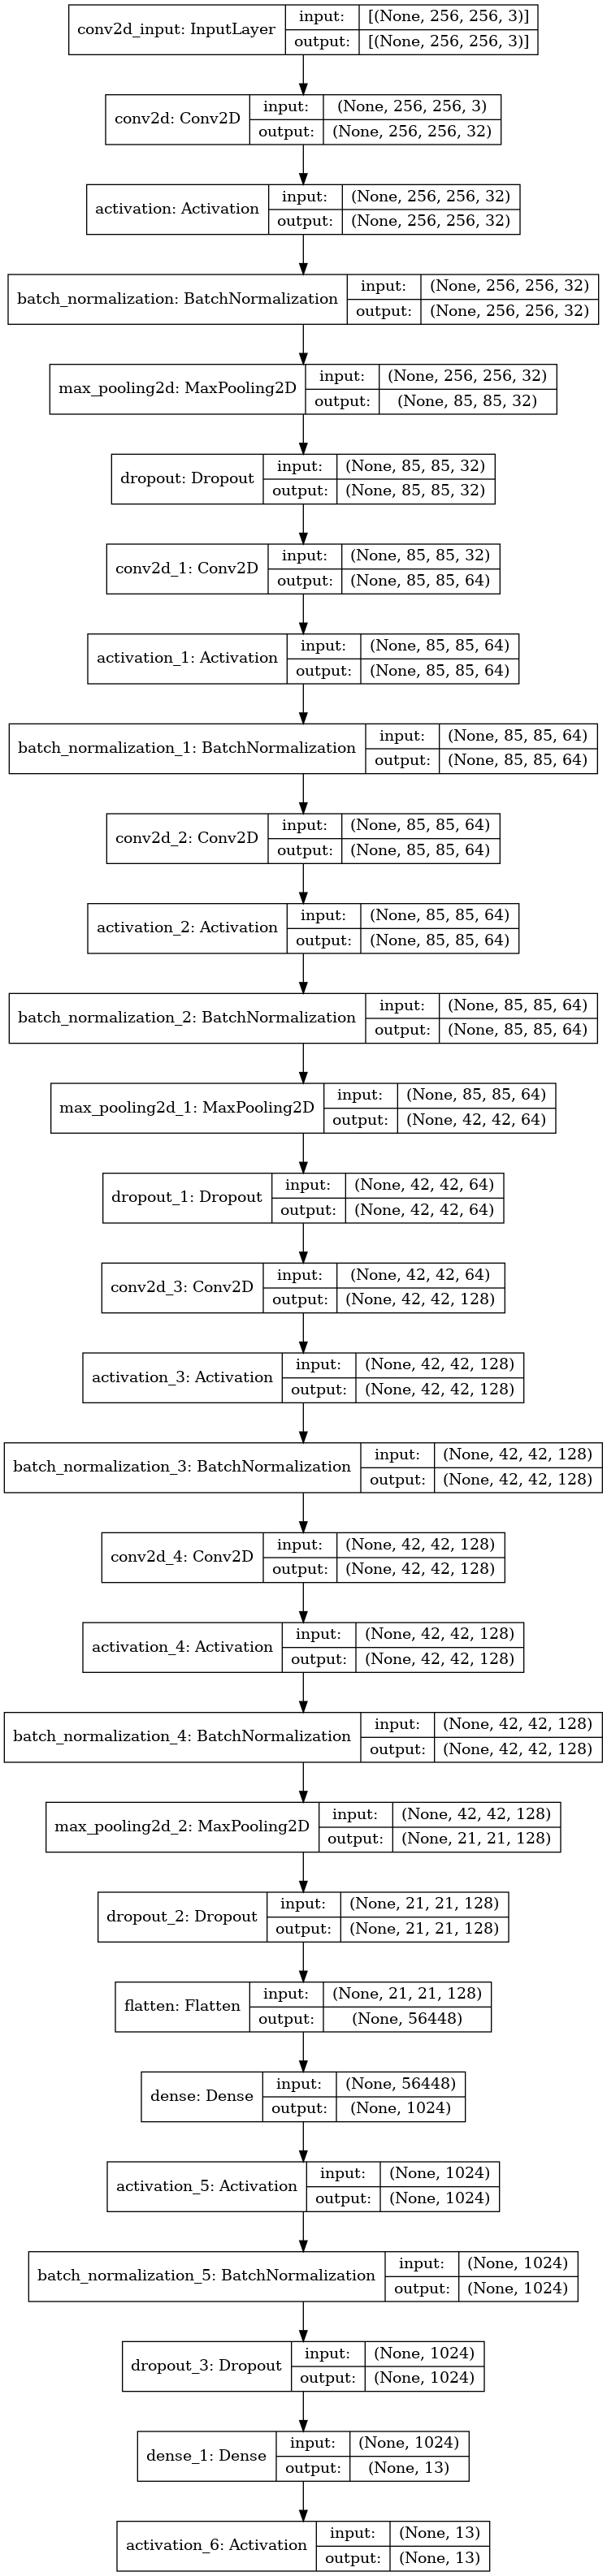

In [3]:
def get_model():
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    print(K.image_data_format())
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))
    
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    # distribution
    model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
    return model
model = get_model()

plot_model(model, '/kaggle/working/model.png', show_shapes=True)

In [4]:
image_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 shear_range=0.2,
                 zoom_range=0.2,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1./255,
                                   validation_split=0.2)

train_generator = image_datagen.flow_from_directory(    
    directory = train_path,
    subset='training',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

valid_generator = image_datagen.flow_from_directory(    
    directory=train_path,
    subset='validation',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(    
    directory=test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    #classes=['.'],
    class_mode="categorical",
    #class_mode=None,
    shuffle=False,
    seed=SEED)

print(train_generator.class_indices)

print(train_generator.samples, valid_generator.samples, test_generator.samples, )

Found 10389 images belonging to 13 classes.
Found 2591 images belonging to 13 classes.
Found 3245 images belonging to 13 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'black_stem_borer': 3, 'blast': 4, 'brown_spot': 5, 'downy_mildew': 6, 'hispa': 7, 'leaf_roller': 8, 'normal': 9, 'tungro': 10, 'white_stem_borer': 11, 'yellow_stem_borer': 12}
10389 2591 3245


In [7]:
!pip install livelossplot

from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping


plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='cnn.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

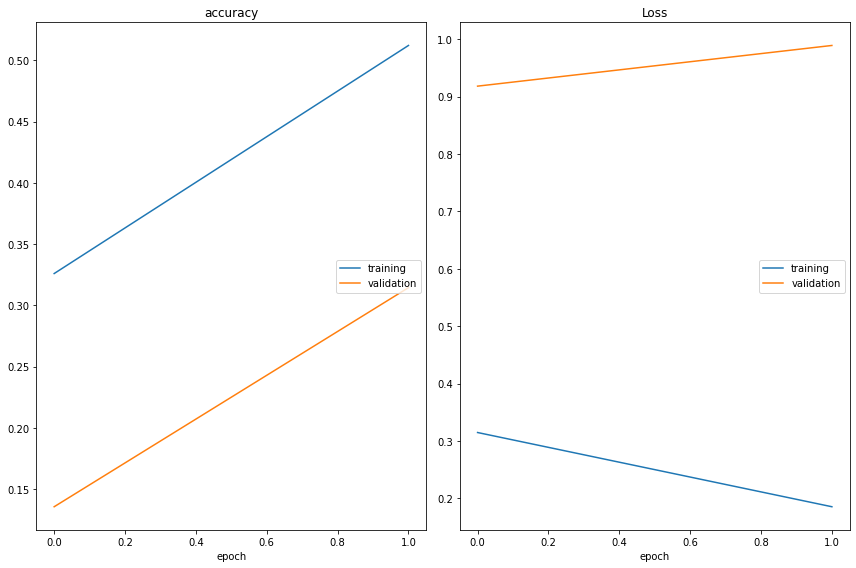

accuracy
	training         	 (min:    0.326, max:    0.512, cur:    0.512)
	validation       	 (min:    0.136, max:    0.314, cur:    0.314)
Loss
	training         	 (min:    0.186, max:    0.315, cur:    0.186)
	validation       	 (min:    0.918, max:    0.989, cur:    0.989)
CPU times: user 8min 28s, sys: 9.26 s, total: 8min 38s
Wall time: 9min 21s


In [8]:
%%time

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

# Retrain model with fine-tuning
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              validation_data = valid_generator,
                              validation_steps = STEP_SIZE_VALID,
                              callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                              verbose=1,epochs=EPOCHS)

# %%time
# STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
# history = model.fit_generator(generator = train_generator,
#                     steps_per_epoch = STEP_SIZE_TRAIN,
#                     validation_data = valid_generator,
#                     validation_steps = STEP_SIZE_VALID,
#                     epochs=EPOCHS)

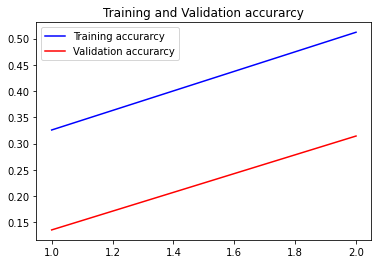

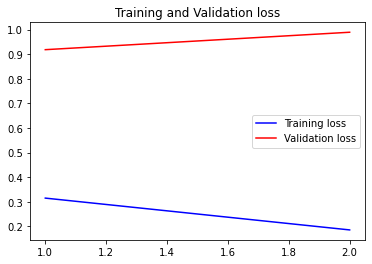

CPU times: user 505 ms, sys: 113 ms, total: 618 ms
Wall time: 604 ms


In [9]:
%%time
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [10]:
print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")
    
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(    
    directory=test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    #classes=['.'],
    #class_mode="categorical",
    class_mode=None,
    shuffle=False,
    seed=SEED)

test images
390 	 tungro
152 	 yellow_stem_borer
431 	 hispa
174 	 downy_mildew
101 	 black_stem_borer
100 	 bacterial_leaf_streak
130 	 bacterial_leaf_blight
253 	 brown_spot
470 	 blast
219 	 leaf_roller
481 	 normal
90 	 bacterial_panicle_blight
254 	 white_stem_borer
Found 3245 images belonging to 13 classes.


In [11]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

model.load_weights('cnn.weights.best.hdf5')
pred = model.predict_generator(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)
pred_classes = np.argmax(pred, axis=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3245/3245 [==============================] - 36s 11ms/step


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class_names = test_generator.class_indices.keys()
true_classes = test_generator.classes

acc = accuracy_score(true_classes, pred_classes)
print("CNN Model Accuracy : {:.2f}%".format(acc * 100))

cls_report = classification_report(true_classes, pred_classes, 
                                   target_names=class_names, digits=5)
print(cls_report)

CNN Model Accuracy : 13.53%
                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.00000   0.00000   0.00000       130
   bacterial_leaf_streak    0.00000   0.00000   0.00000       100
bacterial_panicle_blight    0.00000   0.00000   0.00000        90
        black_stem_borer    0.00000   0.00000   0.00000       101
                   blast    0.00000   0.00000   0.00000       470
              brown_spot    0.05346   0.06719   0.05954       253
            downy_mildew    0.00000   0.00000   0.00000       174
                   hispa    0.14187   0.94896   0.24683       431
             leaf_roller    0.00000   0.00000   0.00000       219
                  normal    0.33333   0.02703   0.05000       481
                  tungro    0.00000   0.00000   0.00000       390
        white_stem_borer    0.00000   0.00000   0.00000       254
       yellow_stem_borer    0.00000   0.00000   0.00000       152

                accuracy                      

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


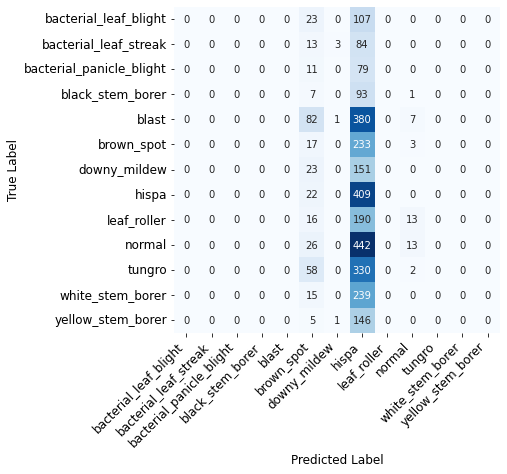

[[  0   0   0   0   0  23   0 107   0   0   0   0   0]
 [  0   0   0   0   0  13   3  84   0   0   0   0   0]
 [  0   0   0   0   0  11   0  79   0   0   0   0   0]
 [  0   0   0   0   0   7   0  93   0   1   0   0   0]
 [  0   0   0   0   0  82   1 380   0   7   0   0   0]
 [  0   0   0   0   0  17   0 233   0   3   0   0   0]
 [  0   0   0   0   0  23   0 151   0   0   0   0   0]
 [  0   0   0   0   0  22   0 409   0   0   0   0   0]
 [  0   0   0   0   0  16   0 190   0  13   0   0   0]
 [  0   0   0   0   0  26   0 442   0  13   0   0   0]
 [  0   0   0   0   0  58   0 330   0   2   0   0   0]
 [  0   0   0   0   0  15   0 239   0   0   0   0   0]
 [  0   0   0   0   0   5   1 146   0   0   0   0   0]]


In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_classes, pred_classes, class_names, ax, title="CNN")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, pred_classes)
print(cm)

In [14]:
loss, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

   1/3245 [..............................] - ETA: 7:24 - loss: 0.0000e+00 - accuracy: 0.0000e+00

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


3245/3245 [==============================] - 30s 9ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
0.0 0.0


In [15]:
pd.Series(train_generator.classes).value_counts()

9     1540
4     1505
7     1376
10    1249
11     816
5      804
8      701
6      556
12     491
0      415
1      324
3      324
2      288
dtype: int64

In [16]:
pd.Series(test_generator.classes).value_counts()

9     481
4     470
7     431
10    390
11    254
5     253
8     219
6     174
12    152
0     130
3     101
1     100
2      90
dtype: int64

In [17]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

hispa           2883
brown_spot       318
normal            39
downy_mildew       5
dtype: int64

In [18]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,image_id,label
0,bacterial_leaf_bligh200091.jpg,brown_spot
1,bacterial_leaf_bligh200112.jpg,hispa
2,bacterial_leaf_bligh200118.jpg,hispa
3,bacterial_leaf_bligh200133.jpg,hispa
4,bacterial_leaf_bligh200220.jpg,hispa
